In [41]:
from control import NonlinearIOSystem, InterconnectedSystem, input_output_response
from numpy import linspace, degrees

from matplotlib.pyplot import figure, rcParams
from conf_matplotlib import conf_matplotlib_horizon
conf_matplotlib_horizon()

In [79]:
def driver_ctl(t, x, u, params):
    nom_sec = params.get("secuencia_pasos", "HSD")
    
    if   nom_sec ==  "WD":
        # Wave drive
        secuencia = [[1,0,0,0], [0,0,1,0], [0,1,0,0], [0,0,0,1]]
        
    elif nom_sec == "FSD":
        # Full step drive
        secuencia = [[1,0,1,0], [0,1,1,0], [0,1,0,1], [1,0,0,1]]
        
    elif nom_sec == "HSD":
        # Half step drive
        secuencia = [[1,0,0,0],[1,0,1,0],[1,1,1,0],[0,1,1,0],
                     [0,1,1,1],[0,1,0,1],[0,0,0,1],[1,0,0,1]]
        
    δ = 0.1
    n = t/δ
    
    m1, m2, m3, m4 = secuencia[int(n)%len(secuencia)]
    
    return [m1, m2, m3, m4]

io_drv_ctl = NonlinearIOSystem(updfcn=None,
                               outfcn=driver_ctl,
                               inputs=(),
                               outputs=("m1", "m2", "m3", "m4"),
                               name="driver_ctl")

In [80]:
def driver_pot(t, x, u, params):
    V = params.get("Vin", 5)
    
    m1, m2, m3, m4 = u
    
    v1 = m1*V
    v2 = m2*V
    v3 = m3*V
    v4 = m4*V
    
    return [v1, v2, v3, v4]

io_drv_pot = NonlinearIOSystem(updfcn=None,
                               outfcn=driver_pot,
                               inputs=("m1", "m2", "m3", "m4"),
                               outputs=("v1", "v2", "v3", "v4"),
                               name="driver_pot")

In [81]:
def elec_input(t, x, u, params):
    v1, v2, v3, v4 = u
    
    ΔV1 = v1 - v2
    ΔV2 = v3 - v4
 
    return [ΔV1, ΔV2]

io_ele_inp = NonlinearIOSystem(None, elec_input,
                               inputs=("v1", "v2", "v3", "v4"),
                               outputs=("ΔV1", "ΔV2"),
                               name="elec_input")

In [82]:
def coil_elec(t, x, u, params):
    L = params.get("L", 0.0015)
    R = params.get("R", 0.55)
    
    ΔV1, ΔV2, e1, e2 = u
    i1, i2 = x
    
    di1 = (ΔV1 - e1 - R*i1)/L
    di2 = (ΔV2 - e2 - R*i2)/L
    
    return [di1, di2]

io_coil_elec = NonlinearIOSystem(coil_elec, None,
                                 inputs=("ΔV1", "ΔV2", "e1", "e2"),
                                 outputs=("i1", "i2"),
                                 states=("i1", "i2"),
                                 name="coil_elec")

In [83]:
def coil_torque(t, x, u, params):
    from numpy import sin, cos
    
    Km = params.get("Km", 0.19)
    n_polos = params.get("n_polos", 50)
    R = params.get("R", 0.55)
    
    i1, i2, e1, e2, θ = u
    
    τ1 = -Km*(i1 - e1/R)*sin(θ*n_polos)
    τ2 =  Km*(i2 - e2/R)*cos(θ*n_polos)
    
    τ = τ1 + τ2
    
    return τ

io_coil_torque = NonlinearIOSystem(None, coil_torque,
                                   inputs=("i1", "i2", "e1", "e2", "θ"),
                                   outputs=("τ"),
                                   name="coil_torque")

In [84]:
def motor_mech(t, x, u, params):
    J = params.get("J", 0.000045)
    B = params.get("B", 0.0008)
    
    τ = u
    θ, ω = x
    
    dθ = ω
    ddθ = (τ - B*ω)/J
    
    return [dθ, ddθ]

io_motor_mech = NonlinearIOSystem(motor_mech, None,
                                  inputs=("τ"),
                                  outputs=("θ", "ω"),
                                  states=("θ", "ω"),
                                  name="motor_mech")

In [85]:
def back_emf(t, x, u, params):
    from numpy import sin, cos
    
    Km = params.get("Km", 0.19)
    n_polos = params.get("n_polos", 50)
    
    θ, ω, i1, i2 = u
    
    e1 = -Km*ω*sin(θ*n_polos)
    e2 =  Km*ω*cos(θ*n_polos)
    
    return [e1, e2]

io_back_emf = NonlinearIOSystem(None, back_emf,
                                inputs=("θ", "ω", "i1", "i2"),
                                outputs=("e1", "e2"),
                                name="back_emf")

In [86]:
systems_list = (io_drv_ctl, io_drv_pot, io_ele_inp,
                io_coil_elec, io_coil_torque, io_motor_mech,
                io_back_emf)

inputs_list  = ()

outputs_list = ("driver_pot.v1", "driver_pot.v2",
                "driver_pot.v3", "driver_pot.v4",
                "coil_elec.i1", "coil_elec.i2",
                "motor_mech.θ", "motor_mech.ω",
                "coil_torque.τ")

connections_list = (("driver_pot.m1", "driver_ctl.m1"),
                    ("driver_pot.m2", "driver_ctl.m2"),
                    ("driver_pot.m3", "driver_ctl.m3"),
                    ("driver_pot.m4", "driver_ctl.m4"),
                    ("elec_input.v1", "driver_pot.v1"),
                    ("elec_input.v2", "driver_pot.v2"),
                    ("elec_input.v3", "driver_pot.v3"),
                    ("elec_input.v4", "driver_pot.v4"),
                    ("coil_elec.ΔV1", "elec_input.ΔV1"),
                    ("coil_elec.ΔV2", "elec_input.ΔV2"),
                    ("coil_torque.i1", "coil_elec.i1"),
                    ("coil_torque.i2", "coil_elec.i2"),
                    ("coil_torque.θ", "motor_mech.θ"),
                    ("motor_mech.τ", "coil_torque.τ"),
                    ("back_emf.θ", "motor_mech.θ"),
                    ("back_emf.ω", "motor_mech.ω"),
                    ("back_emf.i1", "coil_elec.i1"),
                    ("back_emf.i2", "coil_elec.i2"),
                    ("coil_elec.e1", "back_emf.e1"),
                    ("coil_elec.e2", "back_emf.e2"),
                    ("coil_torque.e1", "back_emf.e1"),
                    ("coil_torque.e2", "back_emf.e2"))

sistema = InterconnectedSystem(syslist=systems_list, connections=connections_list,
                               inplist=inputs_list, outlist=outputs_list,
                               name="sistema")

In [87]:
ts = linspace(0, 5, 1000)

In [96]:
t, y = input_output_response(sys=sistema, T=ts, X0=[0,0,0,0],
                             params={"secuencia_pasos":"HSD"})

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/control/iosys.py:776: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(xdot).reshape((-1,))


In [97]:
v1, v2, v3, v4 = y[0:4]
i1, i2 = y[4:6]
θ = degrees(y[6])
ω = degrees(y[7])
τ = y[8]

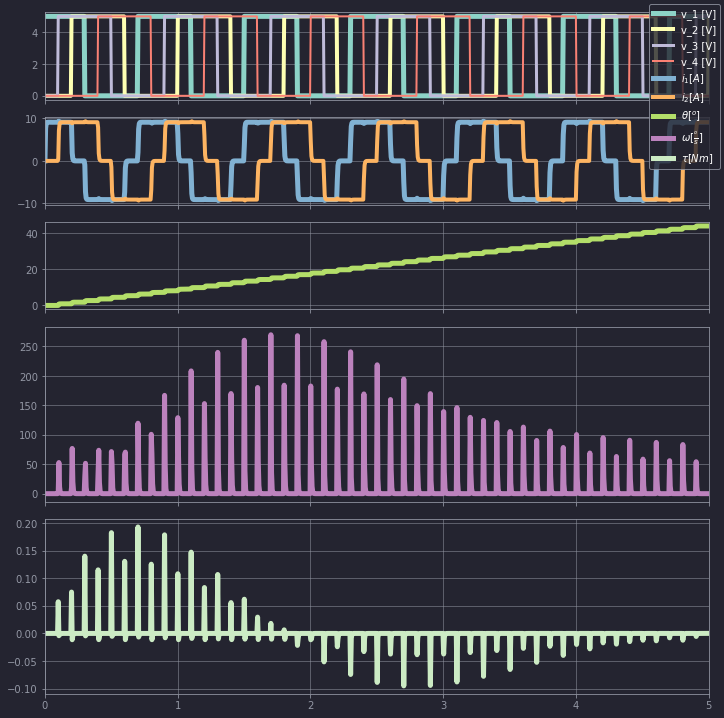

In [98]:
fig = figure(figsize=(10, 10))

axs = fig.subplots(5, 1, sharex='all',
                   gridspec_kw={'height_ratios': [1, 1, 1, 2, 2]})

cycle = rcParams['axes.prop_cycle'].by_key()['color']

axs[0].plot(t, v1, c=cycle[0], label=r"v_1 [V]", lw=5)
axs[0].plot(t, v2, c=cycle[1], label=r"v_2 [V]", lw=4)
axs[0].plot(t, v3, c=cycle[2], label=r"v_3 [V]", lw=3)
axs[0].plot(t, v4, c=cycle[3], label=r"v_4 [V]", lw=2)
axs[1].plot(t, i1, c=cycle[4], label=r"$i_1 [A]$", lw=5)
axs[1].plot(t, i2, c=cycle[5], label=r"$i_2 [A]$", lw=4)
axs[2].plot(t, θ, c=cycle[6], label=r"$\theta [^o]$")
axs[3].plot(t, ω, c=cycle[7], label=r"$\omega [\frac{^o}{s}]$")
axs[4].plot(t, τ, c=cycle[8], label=r"$\tau [Nm]$")

axs[4].set_xlim(min(t), max(t))

fig.legend()
fig.tight_layout();